In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

S = 0.09 # cm2
Pin = 91 # mW/cm2

# Часть 1

In [2]:
vah_data = pd.read_csv('В14.txt', sep='\t', skiprows=7)
vah_data.drop(list(vah_data.columns[-2:]), axis=1, inplace=True)
vah_data.columns = ['U', 'A']

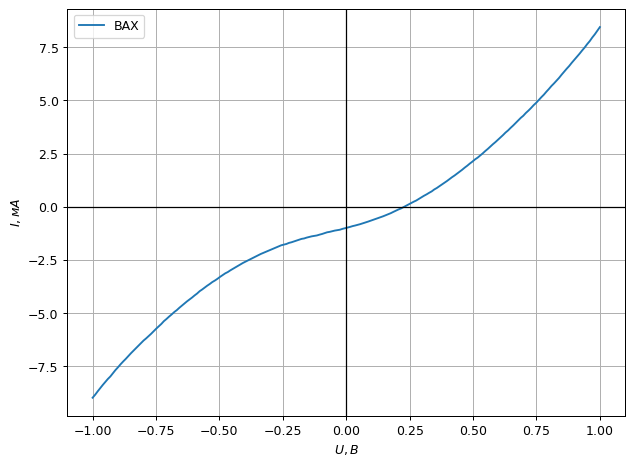

In [3]:
fig, ax1 = plt.subplots(figsize=(8, 6), dpi=90)
ax1.plot(vah_data['U'], vah_data['A'] * 1000, label='ВАХ')
ax1.set_ylabel('$I, мA$')
ax1.set_xlabel('$U, В$')
ax1.axvline(0, c='black', linewidth=1)
ax1.axhline(0, c='black', linewidth=1)
ax1.grid()
ax1.legend();

In [4]:
vah_data = vah_data[(vah_data['U'] > -0.05) & (vah_data['U'] < 0.3)]

In [5]:
vah_data['U2'] = vah_data['U'] ** 2
vah_data['U3'] = vah_data['U'] ** 3
vah_data['U4'] = vah_data['U'] ** 4
vah_data['U5'] = vah_data['U'] ** 5

In [6]:
X = vah_data.drop(['A'], axis=1)
y = vah_data['A']
lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

In [7]:
mean_error_mA = mean_absolute_error(vah_data['A'], lr.predict(X)) * 1000
mape = mean_absolute_percentage_error(vah_data['A'], lr.predict(X)) * 100
print('Средняя абсолютная ошибка:', round(mean_error_mA, 4), 'мA')
print('Средняя относительная ошибка:', round(mape, 4), '%')

Средняя абсолютная ошибка: 0.0033 мA
Средняя относительная ошибка: 1.6891 %


In [8]:
print('Веса перед членами нулевой, первой, ..., пятой степеней')
print([round(each, 5) for each in [lr.intercept_] + list(lr.coef_)])

Веса перед членами нулевой, первой, ..., пятой степеней
[-0.001, 0.00307, 0.0043, -0.00432, 0.08259, -0.16599]


In [9]:
def I_count(U):
    return lr.predict([[U, U**2, U**3, U**4, U**5]])[0]

def derivative_resistance(U, eps=1e-4):
    derivative = (I_count(U + eps) - I_count(U - eps)) / (2 * eps)
    return 1 / derivative

In [10]:
Ikz = I_count(0)

In [11]:
Uxx = 0
while I_count(Uxx) < 0:
    Uxx += 0.0001

In [12]:
U = 0
P_max, I_P_max, U_P_max = 0, 0, 0
P_array = []
while U < Uxx:
    P = abs(U * I_count(U))
    P_array.append(P)
    if P > P_max:
        P_max = P
        I_P_max = I_count(U)
        U_P_max = U
    U += 0.0001

In [13]:
FF = P_max / abs(Ikz * Uxx) * 100
P_in = Pin * S / 1000
mu = (P_max / P_in) * 100
R_sh = derivative_resistance(0)
R_s = derivative_resistance(Uxx)

In [14]:
print('Iкз =', round(Ikz, 6), 'A')
print('Uxx =', round(Uxx, 3), 'B')
print('ФФ =', round(FF, 2), '%')
print('КПД =', round(mu, 3), '%')
print('Rs =', round(R_s, 3), 'Ом')
print('Rsh =', round(R_sh, 3), 'Ом')

Iкз = -0.000996 A
Uxx = 0.228 B
ФФ = 29.57 %
КПД = 0.821 %
Rs = 165.639 Ом
Rsh = 325.552 Ом


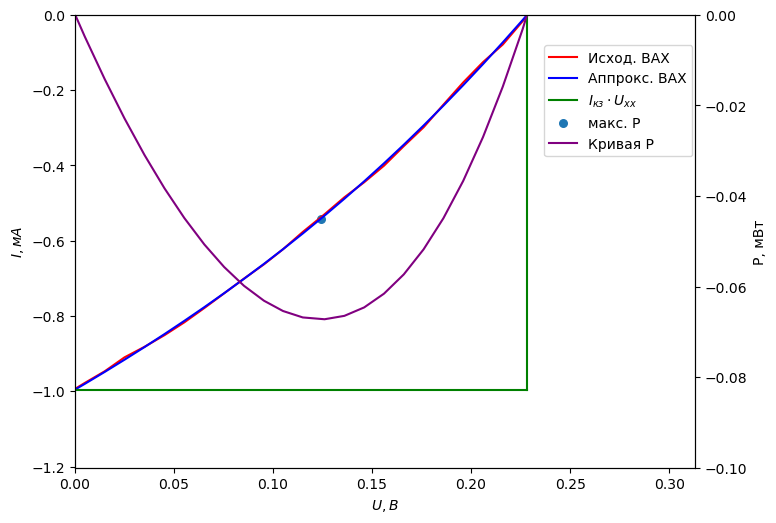

In [15]:
fig, ax1 = plt.subplots(figsize=(8, 6), dpi=100)
ax2 = ax1.twinx()

ax1.plot(vah_data['U'], vah_data['A'] * 1000, label='Исход. ВАХ', c='red')
ax1.plot(vah_data['U'], lr.predict(X) * 1000, label='Аппрокс. ВАХ', c='blue')
ax1.plot(np.linspace(0, Uxx, 50), [Ikz * 1000] * 50, c='green', label='$I_{кз} \cdot U_{xx}$')
ax1.plot([Uxx] * 50, np.linspace(Ikz, 0, 50) * 1000, c='green')
ax1.scatter(U_P_max, I_P_max * 1000, s=30, label='макс. P')
ax1.set_ylim(top=0)
ax1.set_xlim(0)
ax1.set_ylabel('$I, мA$')
ax1.set_xlabel('$U, В$')


ax2.plot(vah_data['U'], vah_data['U'] * lr.predict(X) * 1000, c='purple', label='Кривая P')
ax2.set_xlim(0)
ax2.set_ylim(top=0, bottom=-1e-1)
ax2.set_ylabel('P, мВт')
handles, labels = [(a + b) for a, b in zip(ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels())]
fig.legend(handles, labels, loc=(0.7, 0.7));

# Часть 2

In [16]:
eqe_data = pd.read_excel('В14.xlsx')
eqe_data.columns = ['WL', 'EQE']

In [17]:
am15 = pd.read_csv('ASTMG173.csv', skiprows=1)
am15.columns = ['lambda', 'a', 'W', 'aa']
am15.drop(['a', 'aa'], axis=1, inplace=True)

In [18]:
print('Проверяем, что суммарно интеграл равен 1000 для AM1.5G')
print((am15['lambda'].diff() * am15['W']).sum(), 'Вт/м2')

Проверяем, что суммарно интеграл равен 1000 для AM1.5G
999.7102563234423 Вт/м2


In [19]:
eqe_data['WL2'] = eqe_data['WL'] ** 2
eqe_data['WL3'] = eqe_data['WL'] ** 3
eqe_data['WL4'] = eqe_data['WL'] ** 4
eqe_data['WL5'] = eqe_data['WL'] ** 5

In [20]:
from sklearn.ensemble import RandomForestRegressor
X = eqe_data.drop(['EQE'], axis=1)
y = eqe_data['EQE']
lr2 = RandomForestRegressor(n_estimators=100, random_state=17)
lr2.fit(X, y)

RandomForestRegressor(random_state=17)

In [21]:
mean_error = mean_absolute_error(y, lr2.predict(X))
print('Средняя абсолютная ошибка:', round(mean_error, 4), '%')

Средняя абсолютная ошибка: 0.0843 %


In [22]:
am15 = am15[(am15['lambda'] >= eqe_data['WL'].min()) & (am15['lambda'] <= 860)]

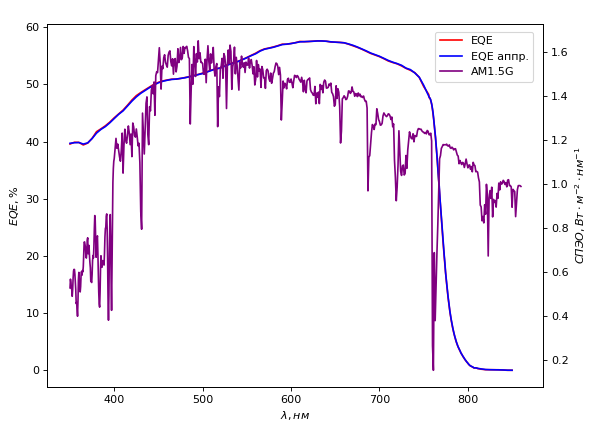

In [23]:
fig, ax1 = plt.subplots(figsize=(8, 6), dpi=80)
ax2 = ax1.twinx()

ax1.plot(eqe_data['WL'], eqe_data['EQE'], label='EQE', c='red')
ax1.plot(eqe_data['WL'], lr2.predict(X), label='EQE аппр.', c='blue')
ax1.set_ylabel('$EQE, \%$')
ax1.set_xlabel('$\lambda, нм$')

ax2.plot(am15['lambda'], am15['W'], c='purple', label='AM1.5G')
ax2.set_ylabel('$СПЭО, Вт\cdotм^{-2}\cdotнм^{-1}$') # спектральная плотность энергетической освещенности
handles, labels = [(a + b) for a, b in zip(ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels())]
fig.legend(handles, labels, loc=(0.73, 0.81));

In [24]:
def EQE_count(WL):
    return lr2.predict([[WL, WL**2, WL**3, WL**4, WL**5]])[0]

In [25]:
WL_Eg = 750
while EQE_count(WL_Eg) > 0:
    WL_Eg += 0.5
    
Eg = 4.135e-15 * 3e8 * 1e9 / WL_Eg
print('WL_Eg =', round(WL_Eg, 1), 'нм')
print('Eg =', round(Eg, 3), 'эВ')

WL_Eg = 828.0 нм
Eg = 1.498 эВ


In [26]:
am15 = am15[(am15['lambda'] >= eqe_data['WL'].min()) & (am15['lambda'] <= WL_Eg)]
am15['EQE'] = am15['lambda'].apply(lambda x: EQE_count(x))
am15['lambda/h'] = am15['lambda'] / (4.135e-15 * 3e8 * 1e9)

In [27]:
Jkz = (am15['lambda'].diff() * am15['EQE'] / 100 * am15['W'] / 10000 * am15['lambda/h']).sum() * 1000
print('Jкз =', round(Jkz, 3), 'А/см2')

Jкз = 13.302 А/см2


In [28]:
am15.to_csv('am15.csv', index=False)